<h1 align="center">Use Line Fitting to Detect Road Lane in Images Taken from Front of Car </h1>

In this notebook, we use Hough transform to detect road lane in images. For verifying the implementation, we test it on four separate images. The images used in this notebook are from IIITB campus except one which is taken from the internet.

### Import Relevant Libraries and Plot the Input Images

In [1]:
#Import relevant libraries
import numpy as np
import cv2 as cv2 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
#Function to plot figures
def plotFigures(imgs, size, isGrey):
  plt.figure(figsize=(size[0], size[1]))  
  for i in range(4):
    plt.subplot(2,2,i+1)
    if(isGrey):
      plt.imshow(imgs[i], cmap='gray')
    else:
      plt.imshow(imgs[i])
  plt.show()

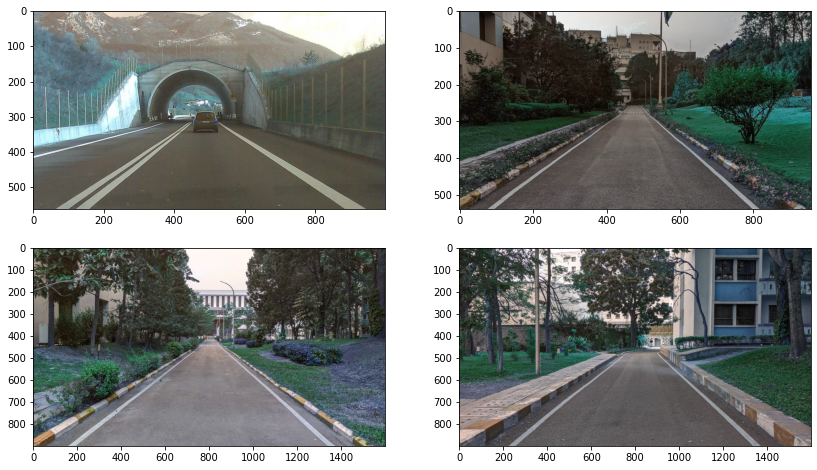

In [3]:
#Read and plot the images
img1 = cv2.imread('road1.jpg')
img2 = cv2.imread('road2.jpeg')
img3 = cv2.imread('road3.jpeg')
img4 = cv2.imread('road4.jpeg')

plotFigures([img1, img2, img3, img4], [14, 8], False)

### Apply Canny Edge Detector on All the Images

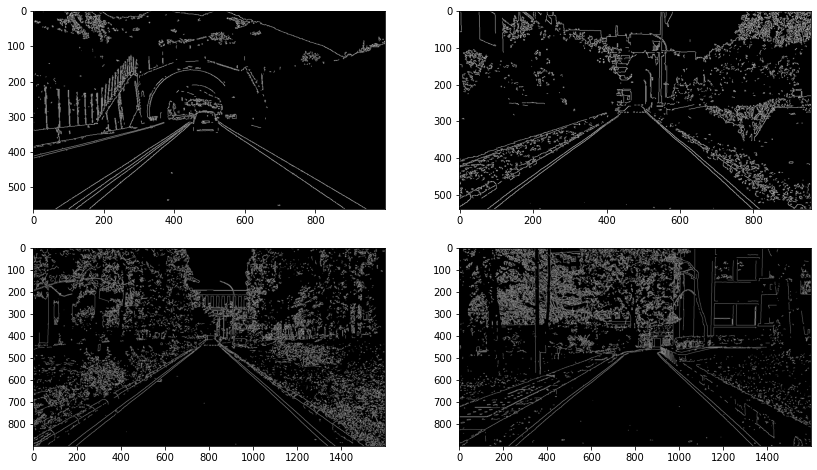

In [4]:
#Apply Canny Edge detector on all images
canny1 = cv2.Canny(img1, 200, 300)
canny2 = cv2.Canny(img2, 200, 300)
canny3 = cv2.Canny(img3, 200, 300)
canny4 = cv2.Canny(img4, 200, 300)

plotFigures([canny1, canny2, canny3, canny4], [14, 8], True)

### Create and Apply Triangular Mask on the Images

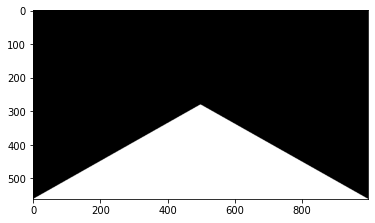

In [5]:
#Get the figure shapes
h1, w1 = canny1.shape
h2, w2 = canny2.shape
h3, w3 = canny3.shape
h4, w4 = canny4.shape

#Plot a Triangular mask
mask = np.zeros_like(canny1)
cv2.fillPoly(mask, pts=[np.array([[0,h1], [w1//2,h1//2], [w1, h1]])], color=(255,255,255))
plt.imshow(mask, cmap='gray')
plt.show()

In [6]:
#This function creates a white triange and does elementwise AND of the triangle 
#with the image to remove the excess noise
def applyMask(img, vertices):
  polygon = np.zeros_like(img)
  cv2.fillPoly(polygon, pts=[vertices], color=(255,255,255))
  # cv2_imshow(polygon)
  img = img & polygon
  return img

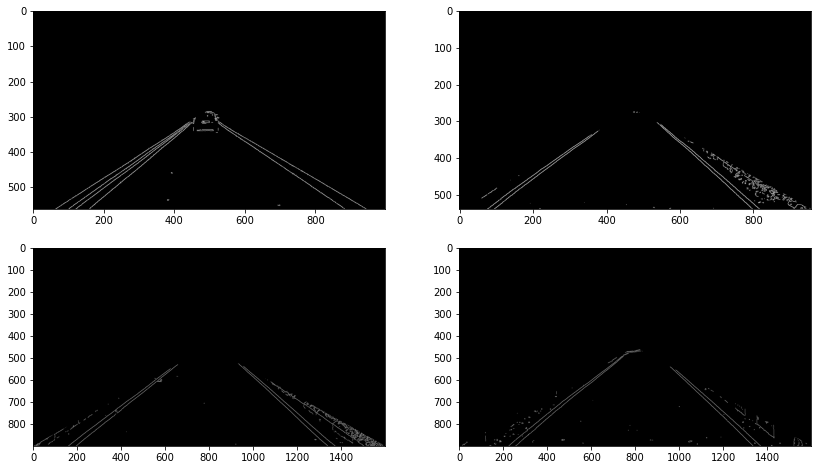

In [7]:
#Apply the mask to remove excess noise from the images
maskedImg1 = applyMask(canny1, np.array([[0,h1], [w1//2,h1//2], [w1, h1]]))
maskedImg2 = applyMask(canny2, np.array([[0,h2], [w2//2,h2//2], [w2, h2]]))
maskedImg3 = applyMask(canny3, np.array([[0,h3], [w3//2,h3//2], [w3, h3]]))
maskedImg4 = applyMask(canny4, np.array([[0,h4], [w4//2,h4//2], [w4, h4]]))

plotFigures([maskedImg1,maskedImg2,maskedImg3,maskedImg4],[14, 8], True)

### Plot the Parameter Space of Images

In [8]:
#Plots the graph of rho vs theta
def plotRhoVsTheta(xpts, ypts, imgNo):
  plt.figure(figsize=(12, 6))  
  for i in range(len(xpts)):
    plt.plot(xpts[i], ypts[i], linewidth=0.003, color='black')
  # ax = plt.axes()
  # ax.set_facecolor("black")
  plt.ylabel(r'$\rho$', fontsize=15)
  plt.xlabel(r'$\theta$', fontsize=15)
  plt.title('Parameter Space for ' + imgNo, fontsize=18)
  plt.show()

For an input image, we plot four lines (two on each side of the lane). The <i>getBoundaryParams</i> function given below uses Hough transform to plot the parameter space for the image.
The parameter space of image is found out using the equation:

$$ xsin(θ) - ycos(θ) + ρ = 0 $$

Where $x$ and $y$ is the coordinate of a white pixel in the image. The unknowns are $θ$ and $ρ$. 

Once the paramenter space is plotted, four pairs of $\rho$ and $θ$ are returned. These pairs are the x($\theta$) and y($\rho$) indices of the accumulator array with highest counts.

In [9]:
#This function returns the desired Rho and Theta for an input image. 
def getBoundaryParams(Img, imgNo):
  #Initialize Parameters
  height, width = Img.shape
  a = np.zeros((180, 2*(width + height)), dtype=float)
  xpts, ypts = [], []
  ylowest, yhighest = 1000000, -1000000
  theta1, theta2, theta3, theta4 = 0, 0, 0, 0
  rho1, rho2, rho3, rho4 = 0, 0, 0, 0

  #Get rho and theta for all white points
  for x in range(0, width):
    for y in range(height//2, height):
      #If the pixel is white, we iterate from theta = 0 to 180 degrees
      if(Img[y][x] > 0):
        #xpt and ypt store the pairs of rho and theta
        xpt, ypt = [], []
        #For each theta from 0 to 180, we get a corresponding rho
        for theta in range(0, 180):
          rho = int(y*np.cos(theta*np.pi/180) - x*np.sin(theta*np.pi/180))  
          xpt.append(theta)
          ypt.append(rho)
          #We keep track of lowest and highest rho for size of accumulator array
          if(rho < ylowest):
            ylowest = rho
          if(rho > yhighest):
            yhighest = rho
        xpts.append(xpt)
        ypts.append(ypt)

  #Plot the parameter space
  plotRhoVsTheta(xpts, ypts, imgNo)

  #For each rho and theta, increase the count in accumulator array
  for i in range(len(xpts)):
    for j in range(len(xpts[i])):
      a[xpts[i][j]][ypts[i][j]-ylowest] += 1

  #Find the four desired pairs of rhos and thetas
  (theta1, rho1) = np.unravel_index(a.argmax(), a.shape)
  a[theta1][rho1] = -1
  (theta2, rho2) = np.unravel_index(a.argmax(), a.shape)
  a[theta2][rho2] = -1
  (theta3, rho3) = np.unravel_index(a.argmax(), a.shape)
  a[theta3][rho3] = -1
  (theta4, rho4) = np.unravel_index(a.argmax(), a.shape)

  return [[theta1, theta2, theta3, theta4], [rho1+ylowest, rho2+ylowest, rho3+ylowest, rho4+ylowest]]

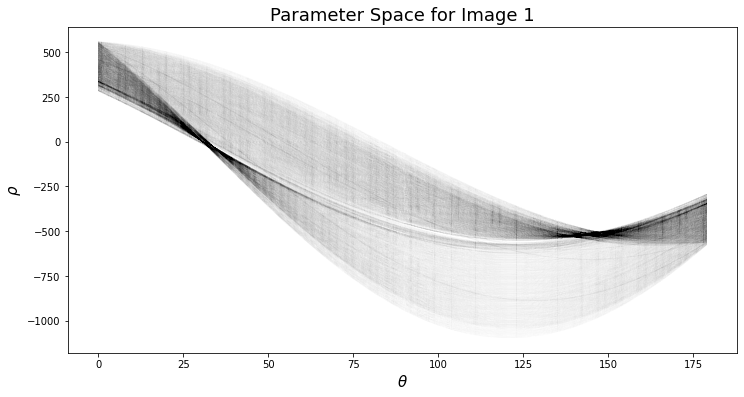

In [10]:
params1 = getBoundaryParams(maskedImg1, 'Image 1')

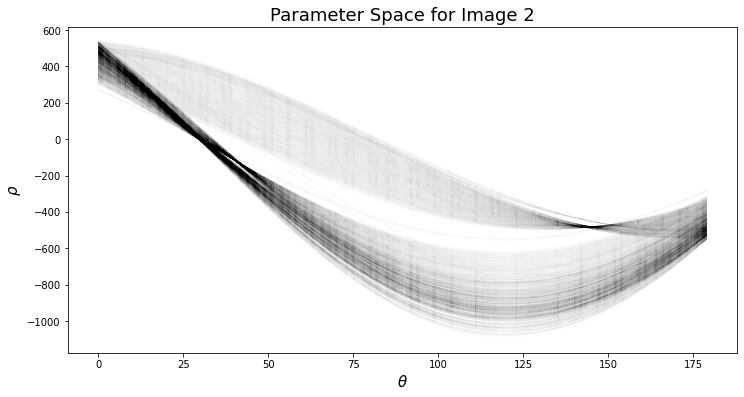

In [11]:
params2 = getBoundaryParams(maskedImg2, 'Image 2')

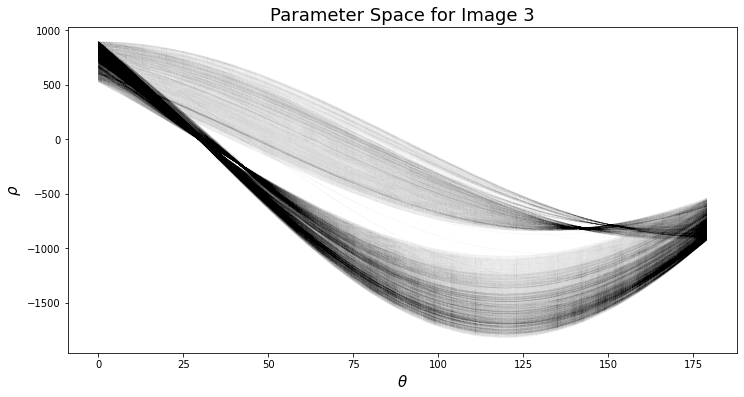

In [12]:
params3 = getBoundaryParams(maskedImg3, 'Image 3')

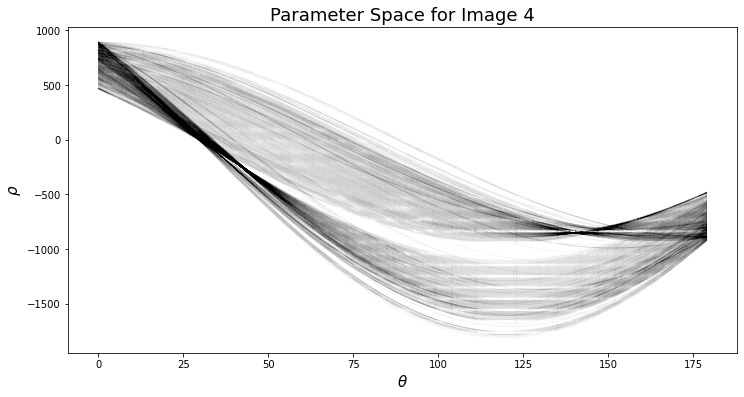

In [13]:
params4 = getBoundaryParams(maskedImg4, 'Image 4')

### Get the Pixel Coordinates of Lanes from Rho and Theta

In [14]:
#This function takes the four values of rho and theta for each image and returns 
#the coordinates of four line segments that needs to be drawn on the image
def endPtsBoundaries(Img, params):
  endPts = []
  y1 = Img.shape[0]
  y2 = int(y1 // 1.75)
  thetas, rhos = params[0], params[1]
  for i in range(len(thetas)):
    x1 = int(y1//np.tan(thetas[i]*np.pi/180) - rhos[i]//np.sin(thetas[i]*np.pi/180))
    x2 = int(y2//np.tan(thetas[i]*np.pi/180) - rhos[i]//np.sin(thetas[i]*np.pi/180))
    endPts.append([(x1, y1), (x2, y2)])
  return endPts

In [15]:
Img1Bndry = endPtsBoundaries(img1, params1)
Img2Bndry = endPtsBoundaries(img2, params2)
Img3Bndry = endPtsBoundaries(img3, params3)
Img4Bndry = endPtsBoundaries(img4, params4)

### Plot the Output Images

In [16]:
#This function takes the pixel coordinates of line segments and plots it on the 
#image
def plotBoundaries(Img, ImgBndry):
  for i in range(len(ImgBndry)):
    Img = cv2.line(Img, ImgBndry[i][0], ImgBndry[i][1], (0, 255, 0), 6)
  return Img

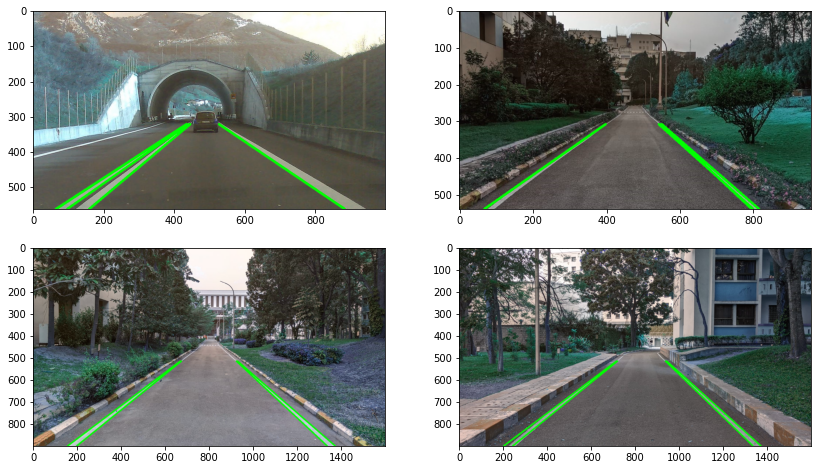

In [17]:
output1 = plotBoundaries(img1, Img1Bndry)
output2 = plotBoundaries(img2, Img2Bndry)
output3 = plotBoundaries(img3, Img3Bndry)
output4 = plotBoundaries(img4, Img4Bndry)

plotFigures([output1, output2, output3, output4], [14, 8], False)

In [18]:
#Output the relevant images
cv2.imwrite('output1.jpeg', output1)
cv2.imwrite('output2.jpeg', output2)
cv2.imwrite('output3.jpeg', output3)
cv2.imwrite('output4.jpeg', output4)

cv2.imwrite('canny1.jpeg', canny1)
cv2.imwrite('canny2.jpeg', canny2)
cv2.imwrite('canny3.jpeg', canny3)
cv2.imwrite('canny4.jpeg', canny4)

cv2.imwrite('masked1.jpeg', maskedImg1)
cv2.imwrite('masked2.jpeg', maskedImg2)
cv2.imwrite('masked3.jpeg', maskedImg3)
cv2.imwrite('masked4.jpeg', maskedImg4)

True